In [9]:
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import shap
import numpy as np
import os

In [10]:
path_to_data = os.path.join(os.path.expanduser('~'), "Documents/CatTheory/CO2RR_selectivity_ML/Data/Datasets/BSc/smogn")

df = pd.read_csv(path_to_data + "/smogn_H2", index_col=False)

X = df.iloc[:,1:8]
y = df.iloc[:,-1]

In [11]:
def ensemble(train, rsm, learning_rate, depth, l2_leaf_reg, iterations, bagging_temperature, num_samples=10):
    ens_preds = []
    for seed in range(num_samples):
        model = CatBoostRegressor(random_seed=seed, rsm=rsm, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, iterations=iterations, bagging_temperature=bagging_temperature, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  verbose=False)
        model.fit(train)
        ens_preds.append(model)
    return ens_preds


train_pool = Pool(X, y)

In [12]:
ensemble_models = ensemble(train=train_pool, rsm=0.5, learning_rate=0.3, depth=2, l2_leaf_reg=8, iterations=1500, bagging_temperature=10)

In [13]:
H_upper = X['H*'].max()
H_lower = X['H*'].min()

CO_upper = X['CO*'].max()
CO_lower = X['CO*'].min()

grid = []

for model in ensemble_models:
    for i in np.linspace(H_lower - 0.2, H_upper + 0.2, 100):
        for j in np.linspace(CO_lower - 0.2, CO_upper + 0.2, 100):
            X_test = {'Vnhe': df['Vnhe'].mean(), 'H*': i, 'CO*': j, 'OCCOH*': df['OCCOH*'].mean(), 'OH*': df['OH*'].mean(), 'O*': df['O*'].mean(), 'C*': df['C*'].mean()}

            test_df = pd.DataFrame([X_test])

            prediction = model.predict(test_df)[0]
            #print(f'H*: {i}, CO*: {j}')
            #print(prediction)

            grid.append((i, j, prediction[0], prediction[1]))

In [14]:
grid_df = pd.DataFrame(grid, columns=['H', 'CO', 'RMSE', 'Uncertainty'])

In [15]:
# Grouping the rows by 'Column1' and 'Column2'
grouped = grid_df.groupby(['H', 'CO'])

# Extracting the indices of rows where there are matches in 'Column1' and 'Column2'
matching_indices = [group.index.tolist() for _, group in grouped if len(group) > 1]

dataset = []



model_preds = []

for indices in matching_indices:
    uncertainty = grid_df.iloc[indices, 3]  # 2 is the index of the third column
    pred = grid_df.iloc[indices, 2]
    h = grid_df.iloc[indices[0], 0]
    co = grid_df.iloc[indices[0], 1]
    aleatoric = 2* np.sqrt(np.mean(uncertainty))
    epistemic = 2 * np.std(pred)
    pred_mean = np.mean(pred)



    model_preds.append((h, co, aleatoric, epistemic, pred_mean))


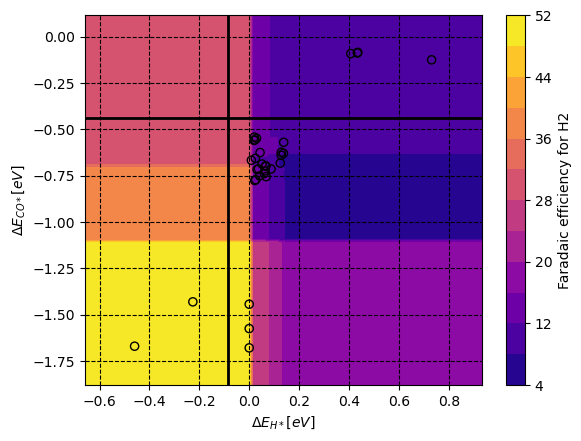

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Provided data
H = [i[0] for i in model_preds]
CO = [i[1] for i in model_preds]
pred = [i[4] for i in model_preds]

# Convert lists to numpy arrays
H = np.array(H)
CO = np.array(CO)
pred = np.array(pred)

# Create grid
xi = np.linspace(H.min(), H.max(), 100)
yi = np.linspace(CO.min(), CO.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((H, CO), pred, (xi, yi), method='cubic')

# Create contour plot
plt.contourf(xi, yi, zi, levels=14, cmap='plasma')
plt.colorbar(label=f'Faradaic efficiency for {y.name}')
#plt.scatter(X, Y, c=pred, s=0.1, cmap='Reds')
plt.scatter(X['H*'], X['CO*'], s=35, facecolors='none', edgecolors='black')
#plt.colorbar()
plt.grid(color='black', linestyle='--')
plt.xlabel('$\Delta E_{H*} [eV]$')
plt.ylabel('$\Delta E_{CO*} [eV]$')
plt.ylim((CO[0],CO[-1]))
plt.xlim((H[0],H[-1]))
plt.plot([-5,5],[-0.44,-0.44],'k',lw=2)
plt.plot([-0.08429,-0.08429],[-5,5],'k',lw=2)

path_to_figs = os.path.join(os.path.expanduser('~'), "Dropbox/Apps/Overleaf/bsc_project/graphics/")

plt.savefig(path_to_figs + f'RMSE_search_{y.name}.pdf', bbox_inches='tight')

plt.show()

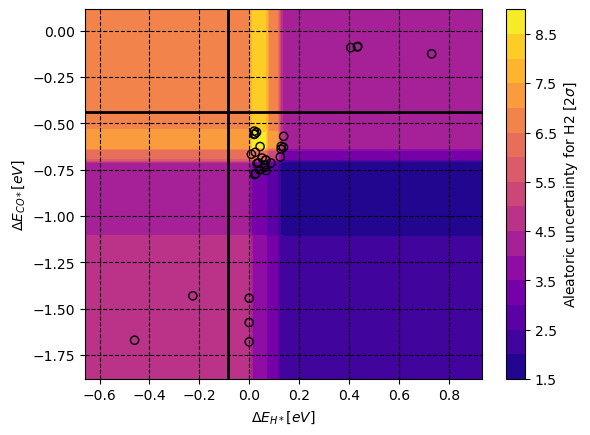

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Provided data
H = [i[0] for i in model_preds]
CO = [i[1] for i in model_preds]
aleatoric_var = [i[2] for i in model_preds]

# Convert lists to numpy arrays
H = np.array(H)
CO = np.array(CO)
var = np.array(aleatoric_var)

# Create grid
xi = np.linspace(H.min(), H.max(), 100)
yi = np.linspace(CO.min(), CO.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((H, CO), var, (xi, yi), method='cubic')

# Create contour plot
plt.contourf(xi, yi, zi, levels=14, cmap='plasma')
plt.colorbar(label=f'Aleatoric uncertainty for {y.name} [$2 \sigma$]')
#plt.scatter(X, Y, c=pred, s=0.1, cmap='Reds')
plt.scatter(X['H*'], X['CO*'], s=35, facecolors='none', edgecolors='black')
#plt.colorbar()
plt.grid(color='black', linestyle='--')
plt.xlabel('$\Delta E_{H*} [eV]$')
plt.ylabel('$\Delta E_{CO*} [eV]$')
plt.ylim((CO[0],CO[-1]))
plt.xlim((H[0],H[-1]))
plt.plot([-5,5],[-0.44,-0.44],'k',lw=2)
plt.plot([-0.08429,-0.08429],[-5,5],'k',lw=2)

path_to_figs = os.path.join(os.path.expanduser('~'), "Dropbox/Apps/Overleaf/bsc_project/graphics/")

plt.savefig(path_to_figs + f'aleatoric_search_{y.name}.pdf', bbox_inches='tight')

plt.show()

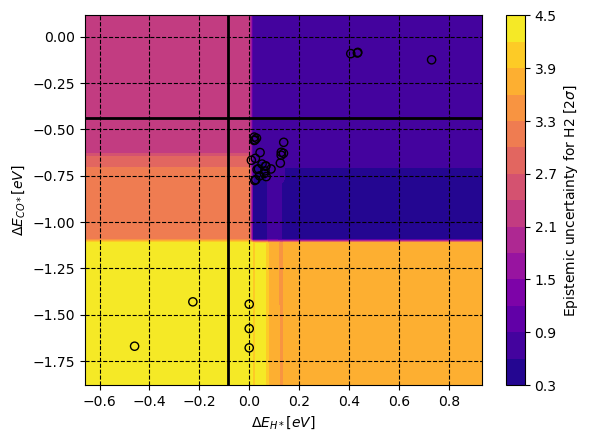

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Provided data
H = [i[0] for i in model_preds]
CO = [i[1] for i in model_preds]
epistemic_var = [i[3] for i in model_preds]

# Convert lists to numpy arrays
H = np.array(H)
CO = np.array(CO)
var = np.array(epistemic_var)

# Create grid
xi = np.linspace(H.min(), H.max(), 100)
yi = np.linspace(CO.min(), CO.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((H, CO), var, (xi, yi), method='cubic')

# Create contour plot
plt.contourf(xi, yi, zi, levels=14, cmap='plasma')
plt.colorbar(label=f'Epistemic uncertainty for {y.name} [$2 \sigma$]')
#plt.scatter(X, Y, c=pred, s=0.1, cmap='Reds')
plt.scatter(X['H*'], X['CO*'], s=35, facecolors='none', edgecolors='black')
#plt.colorbar()
plt.grid(color='black', linestyle='--')
plt.xlabel('$\Delta E_{H*} [eV]$')
plt.ylabel('$\Delta E_{CO*} [eV]$')
plt.ylim((CO[0],CO[-1]))
plt.xlim((H[0],H[-1]))
plt.plot([-5,5],[-0.44,-0.44],'k',lw=2)
plt.plot([-0.08429,-0.08429],[-5,5],'k',lw=2)

path_to_figs = os.path.join(os.path.expanduser('~'), "Dropbox/Apps/Overleaf/bsc_project/graphics/")

plt.savefig(path_to_figs + f'epistemic_search_{y.name}.pdf', bbox_inches='tight')

plt.show()